In [28]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

# constants and parameters
J = 1
t_final = np.pi
steps = 20
dt = t_final / steps
theta = 2 * J * dt
time_points = np.linspace(0, t_final, steps)

Circuit Depth: 13


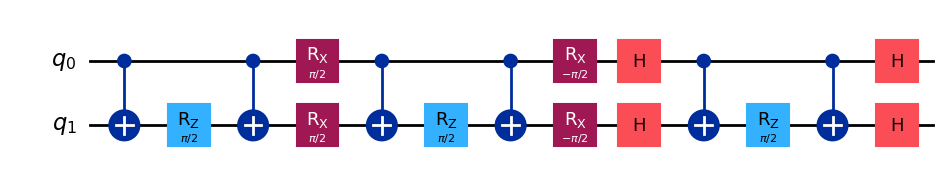

In [33]:
# the circuit for one trotter step

qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.rz(np.pi/2, 1) # (2 * J * dt with J=5, dt=pi/10)
qc.cx(0, 1)

qc.rx(np.pi / 2, [0, 1])
qc.cx(0, 1)
qc.rz(np.pi/2, 1)
qc.cx(0, 1)
qc.rx(-np.pi / 2, [0, 1])

qc.h([0, 1])
qc.cx(0, 1)
qc.rz(np.pi/2, 1)
qc.cx(0, 1)
qc.h([0, 1])
print("Circuit Depth:", qc.depth())
qc.draw('mpl')


Running on 1. Ideal Simulator (Aer Standard)...


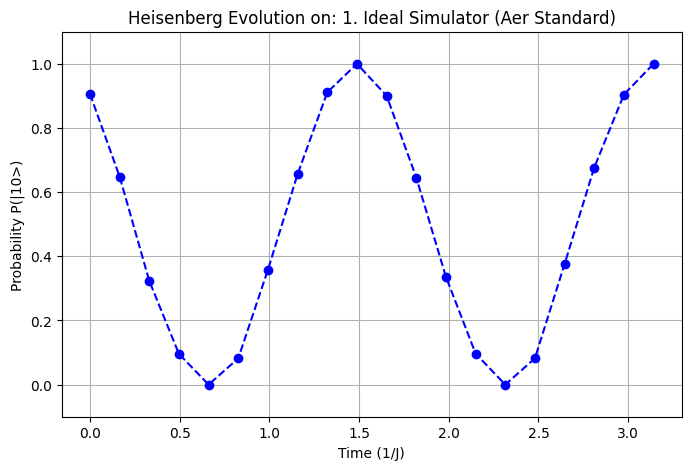

Running on 2. Aer Simulator (MPS Method)...


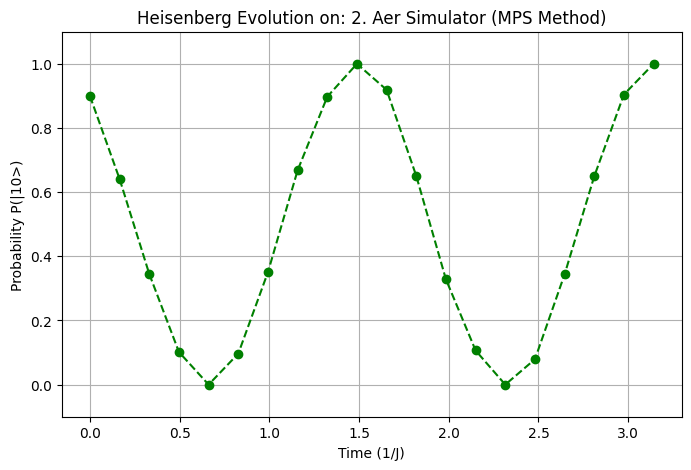

Running on 3. Fake Provider (Sherbrooke Snapshot)...


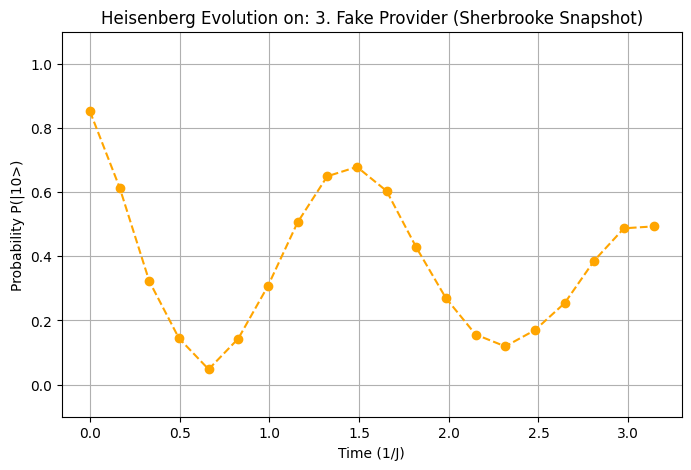

Running on 4. Real Hardware (ibm_torino)...


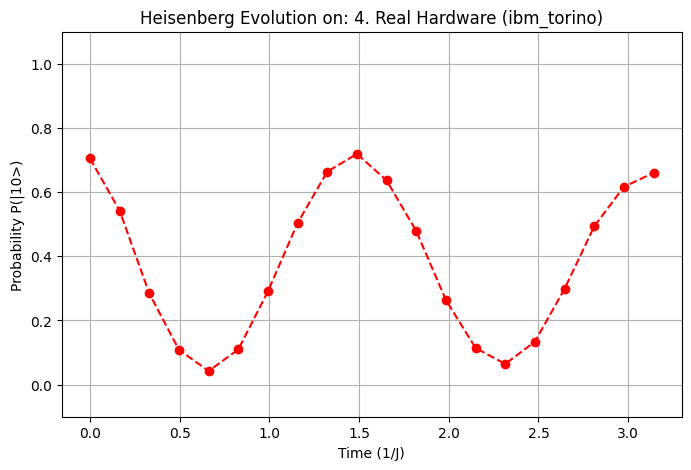

In [ ]:
# Manual Trotter
def build_trotter_circuit(steps, theta):
    qc = QuantumCircuit(2)
    qc.x(0) # Initial state |10> (q0=1, q1=0)
    
    for _ in range(steps):
        # Rzz
        qc.cx(0, 1)
        qc.rz(theta, 1)
        qc.cx(0, 1)
        # Rxx
        qc.h([0, 1])
        qc.cx(0, 1)
        qc.rz(theta, 1)
        qc.cx(0, 1)
        qc.h([0, 1])
        # Ryy
        qc.rx(np.pi/2, [0, 1])
        qc.cx(0, 1)
        qc.rz(theta, 1)
        qc.cx(0, 1)
        qc.rx(-np.pi/2, [0, 1])
        
    qc.measure_all()
    return qc

# Generate a list of circuits for each time step
circuits = [build_trotter_circuit(k+1, theta) for k in range(steps)]

# execution function on different backends
def run_on_backend(backend, circuits, label, color):
    print(f"Running on {label}...")
    
    # transpile
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuits = pm.run(circuits) # isa - instruction set architecture circuits
    
    # execution using the sampler primitive 
    sampler = Sampler(mode=backend)
    job = sampler.run(isa_circuits)
    result = job.result()
    
    # extract probabilities for state '01' (which is |10> in q0,q1)
    probs = []
    for i in range(len(circuits)):
        # SamplerV2 returns data per "pub" (job input)
        # Access counts via .data.<register_name>.get_counts()
        data = result[i].data.meas.get_counts()
        total_shots = sum(data.values())
        # Qiskit is Little Endian: '01' means q1=0, q0=1
        p = data.get('01', 0) / total_shots
        probs.append(p)
        
    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(time_points, probs, marker='o', linestyle='--', color=color)
    plt.title(f"Heisenberg Evolution on: {label}")
    plt.xlabel("Time (1/J)")
    plt.ylabel("Probability P(|10>)")
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.show()

# METHOD 1: Ideal Simulation (Manual Circuit)
backend_ideal = AerSimulator()
run_on_backend(backend_ideal, circuits, "1. Ideal Simulator (Aer Standard)", "blue")

# METHOD 2: AerSimulator with MPS Method
# Simulating via Tensor Networks (Matrix Product States)
# This is efficient for low-entanglement circuits even with many qubits.
backend_mps = AerSimulator(method='matrix_product_state')
run_on_backend(backend_mps, circuits, "2. Aer Simulator (MPS Method)", "green")

# METHOD 3: Fake Provider (Noisy Simulation)
# Simulates the *noise* of a real device (Sherbrooke) locally.
# Good for debugging error mitigation before paying for real runtime.
backend_fake = FakeSherbrooke()
run_on_backend(backend_fake, circuits, "3. Fake Provider (Sherbrooke Snapshot)", "orange")

# METHOD 4: Real Hardware
service = QiskitRuntimeService(channel="ibm_quantum")
backend_real = service.least_busy(operational=True, simulator=False)
run_on_backend(backend_real, circuits, f"4. Real Hardware ({backend_real.name})", "red")